In [1]:
from xpbd_softbody import XPBDSoftbody
import pyvista as pv
import config as cfg
import matplotlib.pyplot as plt
import torch
from xpbd_softbody_layer import XPBDStep
import numpy as np
from sklearn.neighbors import KDTree
from xpbd_softbody_layer import get_energy_boundary
from scipy.interpolate import interp1d
from cubic_bezier import *
from tqdm import trange
from torchmin import minimize_constr

In [2]:
N_skin = 600
N_bandage = 400

In [3]:
# create cubic bezier spline control
u = torch.linspace(0, 1, 3).to(cfg.device)
us = torch.linspace(0, 1, 50).to(cfg.device)
start_point = np.array([[ 0.0098, -0.0098,  0.0035]])
start_point = torch.from_numpy(start_point).to(cfg.device)
## Parallel peeling control
# spline_control = np.array([ [0,  0.0367,  0.57],
#                             [1,  0.0367,  0.67],
#                             [2,  0.0367,  0.77]])
# Straight up peeling control
spline_control = np.array([[ 0.0098, -0.0098,  0.0055],
                           [ 0.0098, -0.0098,  0.0075],
                           [ 0.0098, -0.0098,  0.0095]])
spline_control = torch.from_numpy(spline_control).to(cfg.device)

In [4]:
contact_sur_0 = torch.tensor([ 808,  809,  816,  825,  841,  842,  846,  848,  854,  858,  875,  880,
          882,  885,  904,  916,  917,  919,  926,  927,  928,  929,  930,  931,
          932,  933,  934,  935,  936,  937,  938,  939,  940,  941,  942,  943,
          944,  945,  946,  947,  948,  949,  950,  951,  952,  953,  954,  955,
          956,  957,  958,  959,  960,  961,  962,  963,  964,  965,  966,  967,
          968,  969,  970,  971,  972,  973,  974,  975,  976,  977,  978,  979,
          980,  981,  982,  983,  984,  985,  986,  987,  988,  989,  990,  991,
          992,  993,  994,  995,  996,  997,  998,  999, 1000, 1001, 1002, 1003,
         1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011, 1012, 1013, 1014, 1015,
         1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027,
         1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035, 1036, 1037, 1038, 1039,
         1040, 1041, 1042, 1043, 1044, 1045, 1046, 1047, 1048, 1049, 1050, 1051,
         1052, 1053, 1054, 1055, 1056, 1057, 1058, 1059, 1060, 1061, 1062, 1063,
         1064, 1065, 1066, 1067, 1068]) - 807

contact_sur_1 = torch.tensor([ 43,  50,  51,  54,  60,  61,  92, 103, 104, 106, 108, 110, 117, 154,
         158, 164, 165, 166, 168, 170, 176, 197, 198, 219, 220, 223, 228, 229,
         230, 235, 238, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428,
         429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442,
         443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456,
         457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470,
         471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484,
         485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498,
         499, 500, 501, 502, 503, 504, 505, 506, 507, 508, 509, 510, 511, 512,
         513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526,
         527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540,
         541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 553, 554,
         555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568,
         569, 570, 571, 572, 573, 574, 575, 576, 577, 578, 579, 580, 581, 582,
         583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596,
         597, 598, 599])

In [5]:
control_point = 43

In [6]:
# load data
softbody = XPBDSoftbody()
# skin_mesh = softbody.add_thinshell(pv.Cube(center=(0, 0, 0), x_length=0.02, y_length=0.02, z_length=0.004), n_surf=N_skin)
skin_mesh = softbody.add_mesh(pv.Cube(center=(0, 0, 0), x_length=0.02, y_length=0.02, z_length=0.004), n_surf=N_skin)
# bandage_mesh = softbody.add_mesh(pv.Cube(center=(0, 0, 0.003), x_length=0.02, y_length=0.02, z_length=0.002), n_surf=N_bandage)
bandage_mesh = softbody.add_thinshell(pv.Cube(center=(0, 0, 0.003), x_length=0.02, y_length=0.02, z_length=0.002), n_surf=N_bandage)
softbody.init_states()
softbody.init_dist_constraints()
softbody.init_shape_constraints_thinshell([1])
softbody.add_multi_boundary_constrain(1, 0, 0.0017, contact_sur_0, contact_sur_1)
# softbody.set_gravity(torch.tensor([0, 0, -9.8]).to(cfg.device))
softbody.fix_less_than(0, -0.001, 2)
softbody.fix_point(1, control_point)
# softbody.fix_less_than(1, 0.0022, 2)
# softbody.fix_larger_than(0, 0.0018, 2)
p_skin = skin_mesh.points.shape[0]

detect 2 object


In [7]:
softbody.V_list[1][control_point]

tensor([ 0.0098, -0.0097,  0.0035], dtype=torch.float64)

In [8]:
norm_vec = np.array([-1, 1, 0])
center = (0, 0, 0)
sig_plane = pv.Plane(center=center, direction=norm_vec, i_size=0.01, j_size=0.01)

/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


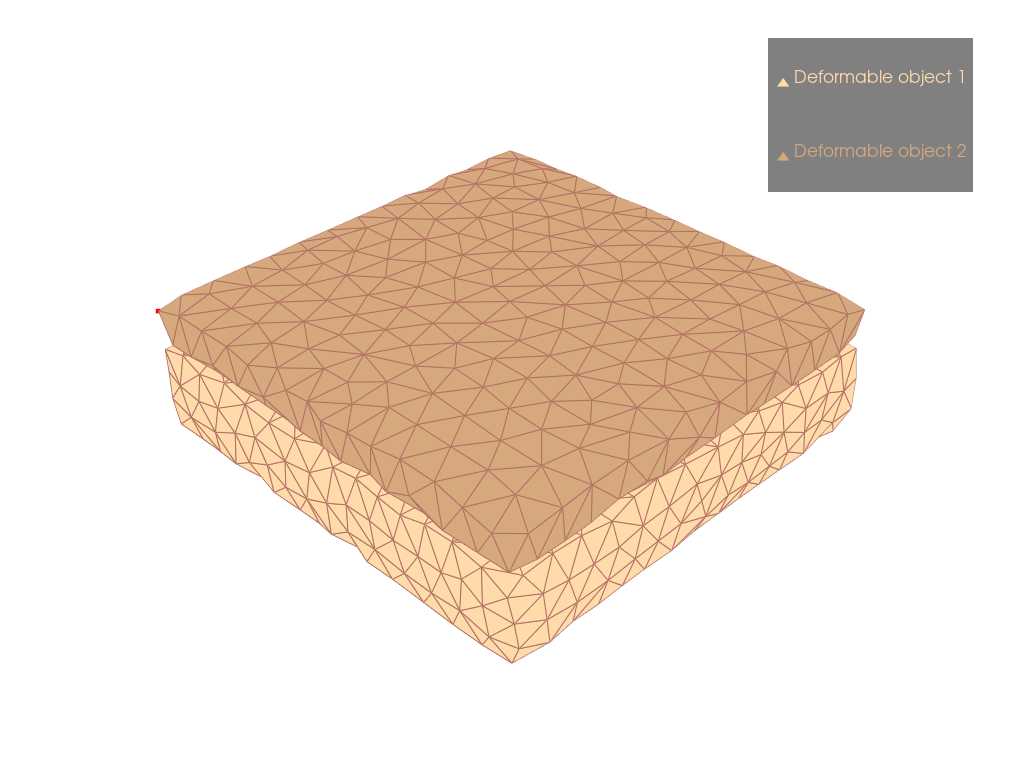

In [9]:
pl = pv.Plotter()
pl.add_mesh(skin_mesh, color='#ffdbac', show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Deformable object 1')
pl.add_mesh(bandage_mesh, color='#D5A97D', show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Deformable object 2')
pl.add_mesh(sig_plane)
pl.add_points(softbody.V[softbody.offset_list[1] + control_point].cpu().numpy(), color='r')
# pl.add_mesh(bandage_mesh, scalars=color, show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Bandage')
pl.add_legend()
pl.camera_position = 'iso'
pl.show()

In [10]:
V_origin = softbody.V.clone()
V_velocity_origin = softbody.V_velocity.clone()

In [11]:
softbody.C_boundary_list[0].shape

torch.Size([754, 2])

In [12]:
# color = np.zeros(400)
# color[306] = 1

In [13]:
cloth_dist_stiffness = 1
V_boundary_stiffness_ref = 0.1
V_dist_stiffness = torch.ones_like(softbody.V_mass).to(cfg.device) * cloth_dist_stiffness
V_boundary_stiffness = torch.ones((softbody.C_boundary_list[0].shape[0], 1)).to(cfg.device) * V_boundary_stiffness_ref
V_boundary_stiffness = V_boundary_stiffness.type(torch.DoubleTensor)
V_shape_stiffness = torch.ones_like(softbody.V_mass).to(cfg.device)*0.0005
energy_threshold = torch.ones((softbody.C_boundary_list[0].shape[0], 1)).to(cfg.device).type(torch.DoubleTensor) * 1e-8
energy_max = 1e-7
energy_min = 1e-8

In [14]:
stiffness_norm = -np.array([1, 1, 0])
stiffness_color = []
cnt = 0
for i in range(contact_sur_0.shape[0]):
    if (stiffness_norm @ softbody.V_list[1][contact_sur_0[i]].detach().cpu().numpy()) < 0:
        energy_threshold[softbody.C_boundary_lut_0[0][i]] = energy_max
        stiffness_color.append(energy_max)
        cnt += 1
    else:
        energy_threshold[softbody.C_boundary_lut_0[0][i]] = energy_min
        stiffness_color.append(energy_min)

In [15]:
# contact_sur.shape[0]

In [16]:
# cnt

In [17]:
# center = torch.tensor([0, 0, 0])
# N_norm = torch.norm(softbody.V_list[1][contact_sur] - center, dim=1)
# stiffness_color = []
# for i in range(contact_sur.shape[0]):
#     energy_threshold[softbody.C_boundary_lut_0[0][i]] = energy_max -  N_norm[i]*(energy_max - energy_min) / (N_norm.max() - N_norm.min()) + energy_max - N_norm.max()*(energy_max - energy_min) / (N_norm.max() - N_norm.min())
#     stiffness_color.append(energy_max - N_norm[i]*(energy_max - energy_min) / (N_norm.max() - N_norm.min()) + energy_max - N_norm.max()*(energy_max - energy_min) / (N_norm.max() - N_norm.min()))

In [18]:
# picked_stiffness = torch.from_numpy(np.array([228, 252, 253, 254, 205, 216, 215, 212, 211, 243, 213, 213, 213, 213, 261, 247, 257, 221, 222, 222, 222, 222, 227, 224, 232, 230]))
# stiffness_color = []
# for i in range(contact_sur.shape[0]):
#     if contact_sur[i] in picked_stiffness:
#         energy_threshold[softbody.C_boundary_lut_0[0][i]] = energy_max
#         stiffness_color.append(energy_max)
#     else:
#         energy_threshold[softbody.C_boundary_lut_0[0][i]] = energy_min
#         stiffness_color.append(energy_min)

In [19]:
torch.sum(energy_threshold == 1e-7)

tensor(383)

In [20]:
V_boundary_stiffness_origin = V_boundary_stiffness.clone()
energy_coff = 15 / energy_threshold

/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


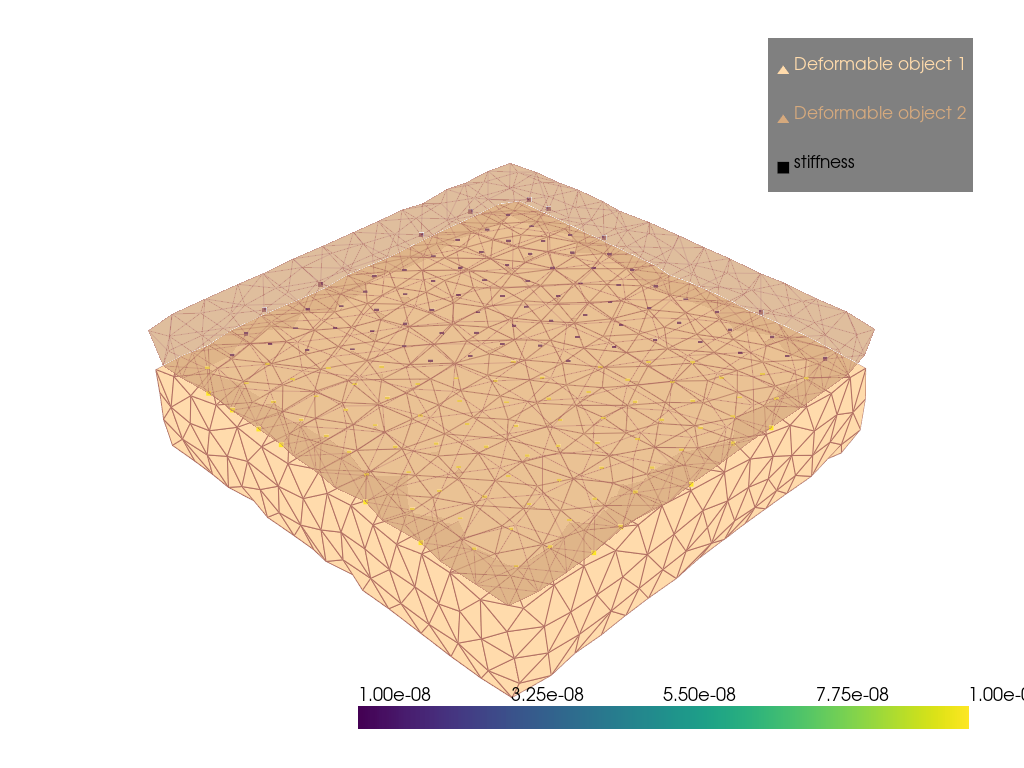

In [21]:
pl = pv.Plotter()
pl.add_mesh(skin_mesh, color='#ffdbac', show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Deformable object 1')
pl.add_mesh(bandage_mesh, color='#D5A97D', show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Deformable object 2', opacity=0.5)
# pl.add_mesh(sig_plane)
pl.add_points(softbody.V_list[1][contact_sur_0].cpu().numpy(), scalars=stiffness_color, label='stiffness')
# pl.add_mesh(bandage_mesh, scalars=color, show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Bandage')
pl.add_legend()
pl.camera_position = 'iso'
pl.show()

In [22]:
select_points = []
for i in range(softbody.V_list[1].shape[0]):
    if (norm_vec @ softbody.V_list[1][i].detach().cpu().numpy()) < 0:
        select_points.append(i + softbody.offset_list[1])

In [23]:
reveal_points = []
for i in softbody.C_boundary_V_0[0]:
    if i in select_points:
        reveal_points.append(i)

/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


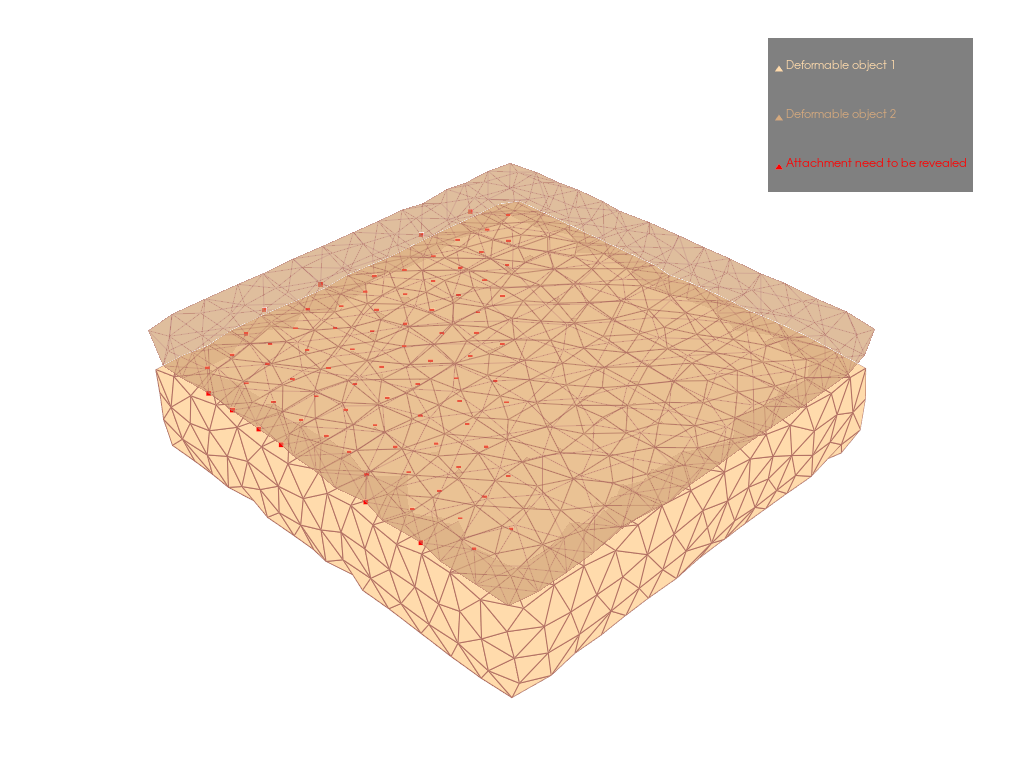

In [24]:
pl = pv.Plotter()
pl.add_mesh(skin_mesh, color='#ffdbac', show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Deformable object 1')
pl.add_mesh(bandage_mesh, color='#D5A97D', show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Deformable object 2', opacity=0.5)
# pl.add_mesh(sig_plane)
pl.add_points(softbody.V[reveal_points].cpu().numpy(), color='r', label='Attachment need to be revealed')
# pl.add_mesh(bandage_mesh, scalars=color, show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Bandage')
pl.add_legend()
pl.camera_position = 'iso'
pl.show()

In [25]:
boundary_mask = torch.ones((softbody.C_boundary_list[0].shape[0], 1)).to(cfg.device) * V_boundary_stiffness_ref
for i in reveal_points:
    idx = torch.where(softbody.C_boundary_V_0[0] == i)[0]
    # print(idx)
    boundary_idx = softbody.C_boundary_lut_0[0][idx]
    boundary_mask[boundary_idx] = 1e-8

In [26]:
softbody.V[softbody.offset_list[1] + 50]

tensor([0.0099, 0.0014, 0.0023])

In [27]:
# Set grad parameter
spline_control.requires_grad_(True)

tensor([[ 0.0098, -0.0098,  0.0055],
        [ 0.0098, -0.0098,  0.0075],
        [ 0.0098, -0.0098,  0.0095]], dtype=torch.float64, requires_grad=True)

In [28]:
optimizer = torch.optim.Adam([spline_control], lr=0.001)

In [29]:
# define loss function
# target = torch.ones_like(V_boundary_stiffness) * 1e-5

def loss_fn(predict, target, penalty, energy, alpha=1e6, beta=1):
    return torch.norm(target - predict) + penalty * alpha# + energy * 1e2 * beta
# def loss_fn(predict, target, penalty, energy, alpha=1e6, beta=1):
#     return energy

In [30]:
## evaluation function
def eval(predict, target):
    predict_revealed = predict < 1e-2
    predict_unrevealed = predict > 1e-2
    # print(torch.sum(predict_revealed))
    target_revealed = target < 1e-2
    target_unrevealed = target > 1e-2

    # calculate arrcuary reveal
    reveal_acc = torch.sum(torch.logical_and(predict_revealed, target_revealed)) / torch.sum(target_revealed)
    unreveal_acc = torch.sum(torch.logical_and(predict_unrevealed, target_unrevealed)) / torch.sum(target_unrevealed)

    return reveal_acc, unreveal_acc

In [31]:
# torch.autograd.set_detect_anomaly(False)
softbody.C_boundary_list[0].shape

torch.Size([754, 2])

In [32]:
spline_list = []

itr 0
start simulation


100%|██████████| 12/12 [00:02<00:00,  5.14it/s]


loss: tensor(1.8167, dtype=torch.float64, grad_fn=<AddBackward0>)
Accuracy: tensor(0.0794) tensor(1.)
avg energy: tensor([7.8531e-07], grad_fn=<DivBackward0>)
constrain tensor(0., dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([[-123.2143,   53.1407,   58.1671],
        [ -97.9047,   56.7741,   -9.6680],
        [ -56.4943,   21.2160,  -12.9437]], dtype=torch.float64)


/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


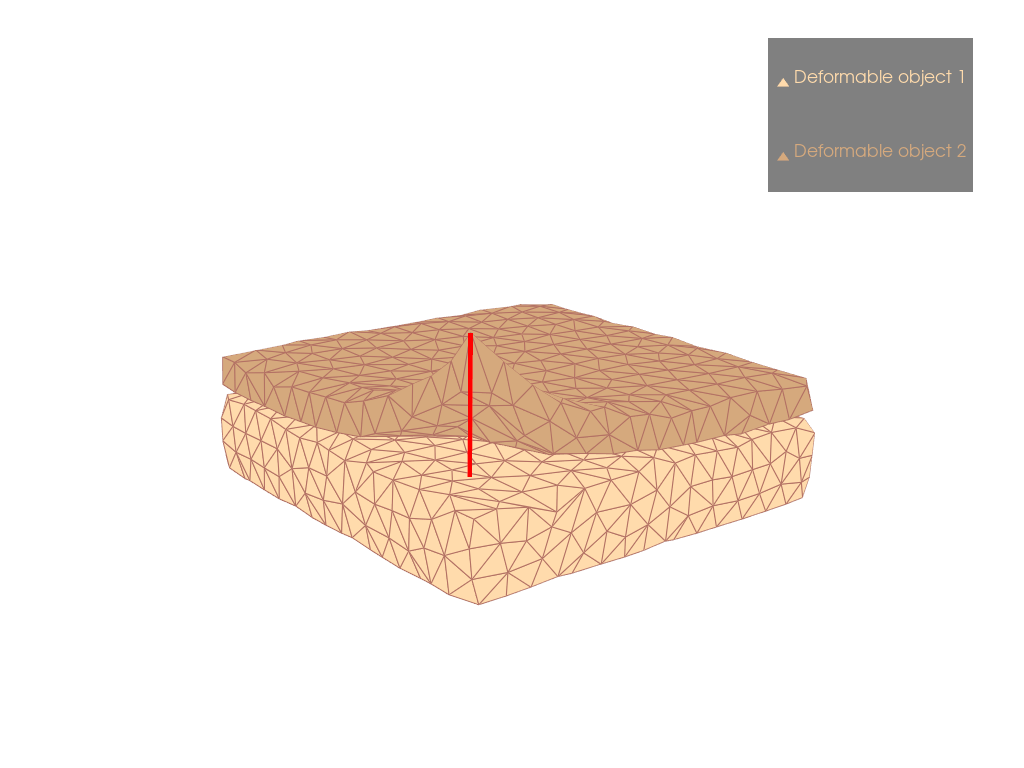

itr 1
start simulation


100%|██████████| 15/15 [00:03<00:00,  4.85it/s]


loss: tensor(1.6862, dtype=torch.float64, grad_fn=<AddBackward0>)
Accuracy: tensor(0.1429) tensor(1.)
avg energy: tensor([1.7565e-06], grad_fn=<DivBackward0>)
constrain tensor(0., dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([[ 82.8679,  94.2691, -41.0437],
        [148.6613,  20.6124,   6.3803],
        [ 27.9278,  24.8210,   0.2337]], dtype=torch.float64)
itr 2
start simulation


100%|██████████| 17/17 [00:03<00:00,  5.28it/s]


loss: tensor(1.6143, dtype=torch.float64, grad_fn=<AddBackward0>)
Accuracy: tensor(0.1534) tensor(1.)
avg energy: tensor([2.6000e-06], grad_fn=<DivBackward0>)
constrain tensor(0., dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([[ 28.9775,  30.1326,  -0.2360],
        [-18.3233,  48.6586,   8.2670],
        [-45.4104,  27.1333,   1.8044]], dtype=torch.float64)
itr 3
start simulation


100%|██████████| 19/19 [00:03<00:00,  5.06it/s]


loss: tensor(1.5032, dtype=torch.float64, grad_fn=<AddBackward0>)
Accuracy: tensor(0.1746) tensor(1.)
avg energy: tensor([3.5420e-06], grad_fn=<DivBackward0>)
constrain tensor(0., dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([[541.9288, -47.4088, -77.8789],
        [211.8628, -53.1498, -34.2071],
        [-25.5239,  32.0661,  -7.7314]], dtype=torch.float64)
itr 4
start simulation


100%|██████████| 21/21 [00:03<00:00,  5.50it/s]


loss: tensor(1.4057, dtype=torch.float64, grad_fn=<AddBackward0>)
Accuracy: tensor(0.2566) tensor(0.9973)
avg energy: tensor([4.4406e-06], grad_fn=<DivBackward0>)
constrain tensor(0., dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([[ 1897.1002,  -952.6847, -2061.9306],
        [  972.6812, -2141.3432,  -215.0282],
        [  175.5691,  -219.4850,    -5.1388]], dtype=torch.float64)
itr 5
start simulation


100%|██████████| 22/22 [00:04<00:00,  5.49it/s]


loss: tensor(1.3952, dtype=torch.float64, grad_fn=<AddBackward0>)
Accuracy: tensor(0.2778) tensor(0.9894)
avg energy: tensor([4.2935e-06], grad_fn=<DivBackward0>)
constrain tensor(0., dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([[833.5734, 456.7810, 151.3525],
        [158.2246,  60.0766, 166.0440],
        [-59.4058,  54.1238,  48.0067]], dtype=torch.float64)


/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


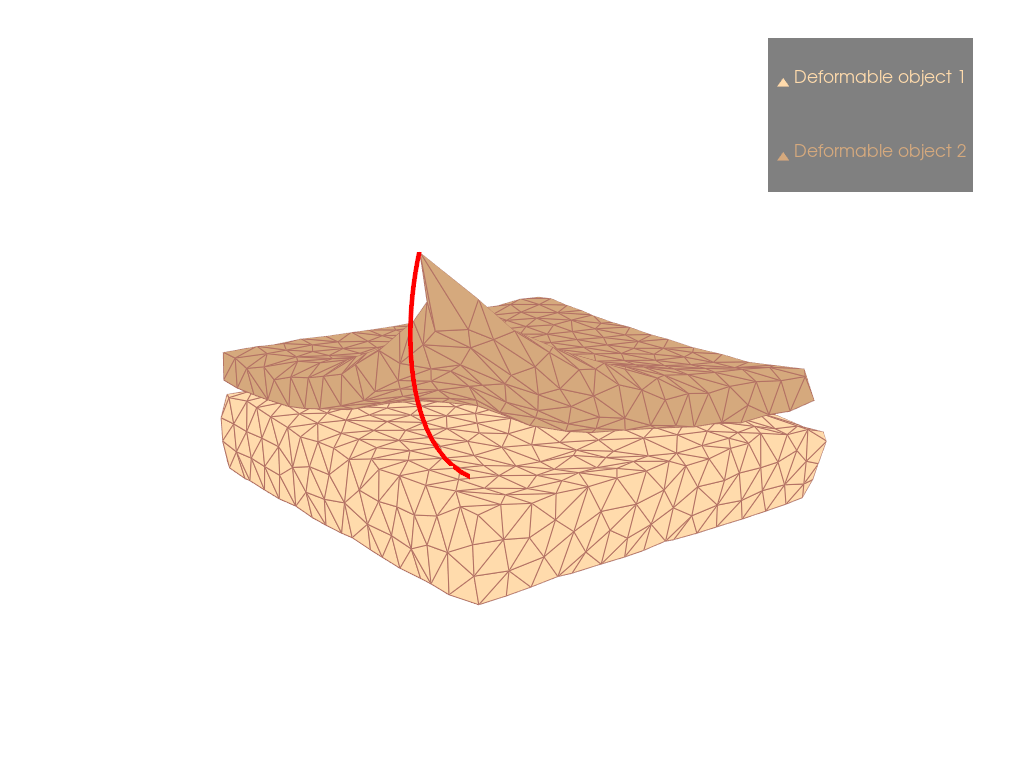

itr 6
start simulation


100%|██████████| 22/22 [00:04<00:00,  4.57it/s]


loss: tensor(1.4015, dtype=torch.float64, grad_fn=<AddBackward0>)
Accuracy: tensor(0.2857) tensor(0.9973)
avg energy: tensor([4.0471e-06], grad_fn=<DivBackward0>)
constrain tensor(0., dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([[-978.7963, 2573.5057, 1131.4528],
        [-220.5787, 2017.7860,  357.1077],
        [-151.6694,  184.9070,   88.9885]], dtype=torch.float64)
itr 7
start simulation


100%|██████████| 22/22 [00:04<00:00,  4.52it/s]


loss: tensor(1.4331, dtype=torch.float64, grad_fn=<AddBackward0>)
Accuracy: tensor(0.2804) tensor(0.9814)
avg energy: tensor([4.0630e-06], grad_fn=<DivBackward0>)
constrain tensor(0., dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([[-1443.4398,   312.6220,    47.9999],
        [ -505.3517,   459.4590,  -111.9092],
        [  -27.6465,   123.4971,   -53.0191]], dtype=torch.float64)
itr 8
start simulation


100%|██████████| 22/22 [00:04<00:00,  4.57it/s]


loss: tensor(1.4295, dtype=torch.float64, grad_fn=<AddBackward0>)
Accuracy: tensor(0.2672) tensor(0.9867)
avg energy: tensor([4.0828e-06], grad_fn=<DivBackward0>)
constrain tensor(0., dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([[-260.1662, 1931.6267, 1249.0143],
        [  89.4110,  979.2688,  237.0053],
        [  51.0440,  151.8530,   -2.7455]], dtype=torch.float64)
itr 9
start simulation


100%|██████████| 22/22 [00:05<00:00,  4.35it/s]


loss: tensor(1.4246, dtype=torch.float64, grad_fn=<AddBackward0>)
Accuracy: tensor(0.2619) tensor(0.9840)
avg energy: tensor([4.2737e-06], grad_fn=<DivBackward0>)
constrain tensor(0., dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([[ 154.6194, -517.5718, -257.1342],
        [ -35.9843, -457.5334,  -42.9724],
        [ -18.3175,  -58.4761,   11.1517]], dtype=torch.float64)
itr 10
start simulation


100%|██████████| 23/23 [00:04<00:00,  4.70it/s]


loss: tensor(1.3909, dtype=torch.float64, grad_fn=<AddBackward0>)
Accuracy: tensor(0.2619) tensor(0.9867)
avg energy: tensor([4.7835e-06], grad_fn=<DivBackward0>)
constrain tensor(0., dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([[ 16.8194, 585.5283, 418.4273],
        [ -5.4805, 350.4377, 198.0614],
        [-14.8763, 102.3327,  39.8454]], dtype=torch.float64)


/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


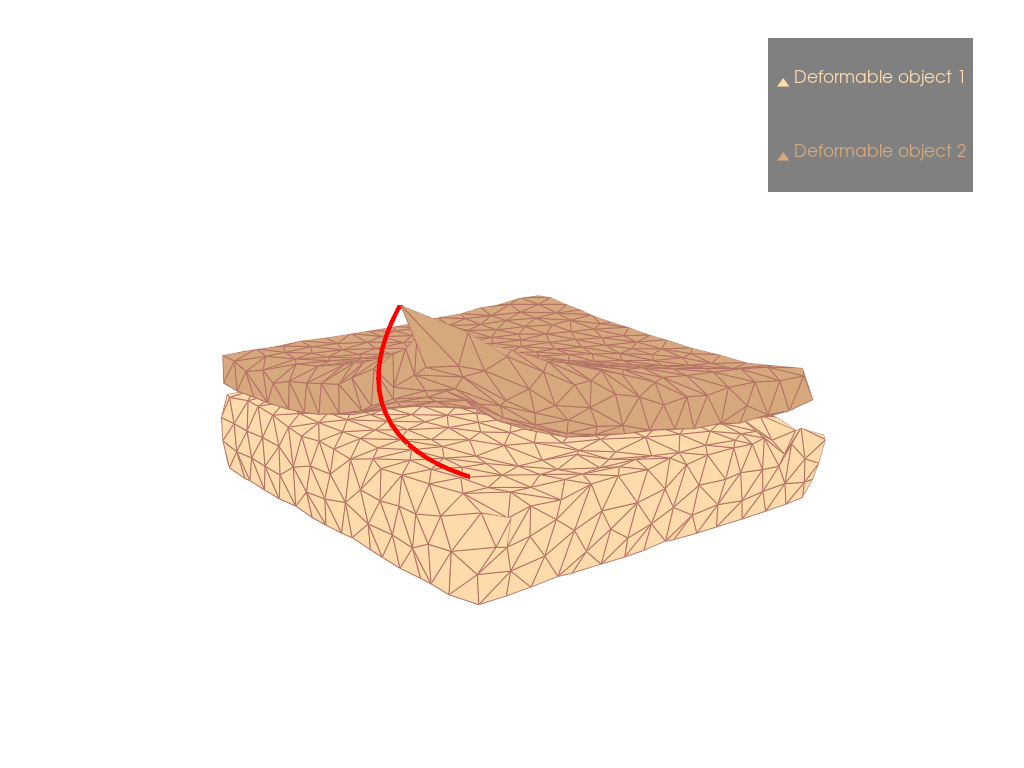

itr 11
start simulation


100%|██████████| 23/23 [00:05<00:00,  4.48it/s]


loss: tensor(1.3742, dtype=torch.float64, grad_fn=<AddBackward0>)
Accuracy: tensor(0.3042) tensor(0.9920)
avg energy: tensor([4.9611e-06], grad_fn=<DivBackward0>)
constrain tensor(0., dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([[ 725.5832, -613.5856,  -24.2680],
        [ 159.0977, -658.5240,   43.1284],
        [ -34.0630, -102.5706,   41.0072]], dtype=torch.float64)
itr 12
start simulation


100%|██████████| 23/23 [00:05<00:00,  4.35it/s]


loss: tensor(1.4056, dtype=torch.float64, grad_fn=<AddBackward0>)
Accuracy: tensor(0.2487) tensor(0.9894)
avg energy: tensor([4.9619e-06], grad_fn=<DivBackward0>)
constrain tensor(0., dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([[  35.6446, -340.1018, -198.0818],
        [-101.8529,  -60.3971,  -73.7655],
        [ -38.4630,   37.2552,   -8.2089]], dtype=torch.float64)
itr 13
start simulation


100%|██████████| 24/24 [00:05<00:00,  4.54it/s]


loss: tensor(1.3561, dtype=torch.float64, grad_fn=<AddBackward0>)
Accuracy: tensor(0.3042) tensor(0.9787)
avg energy: tensor([5.2901e-06], grad_fn=<DivBackward0>)
constrain tensor(0., dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([[-5625.6642,  1050.8492,  -395.2826],
        [-1474.3374,   437.6705,  -481.2897],
        [   53.9840,   400.9468,  -219.9991]], dtype=torch.float64)
itr 14
start simulation


100%|██████████| 24/24 [00:05<00:00,  4.59it/s]


loss: tensor(1.3239, dtype=torch.float64, grad_fn=<AddBackward0>)
Accuracy: tensor(0.3360) tensor(0.9894)
avg energy: tensor([5.6694e-06], grad_fn=<DivBackward0>)
constrain tensor(0., dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([[1345.2866,  -76.1504,  376.9469],
        [ 486.5486, -231.2035,  103.9462],
        [ 159.4728,   41.0808,  -25.8314]], dtype=torch.float64)
itr 15
start simulation


100%|██████████| 25/25 [00:05<00:00,  4.39it/s]


loss: tensor(1.3187, dtype=torch.float64, grad_fn=<AddBackward0>)
Accuracy: tensor(0.3704) tensor(0.9761)
avg energy: tensor([6.2245e-06], grad_fn=<DivBackward0>)
constrain tensor(0., dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([[ 9049.9661, -1587.5657,  -271.2699],
        [ 2384.5797,  -714.8073,  -529.7184],
        [  165.9084,  -669.6949,   -59.6869]], dtype=torch.float64)


/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


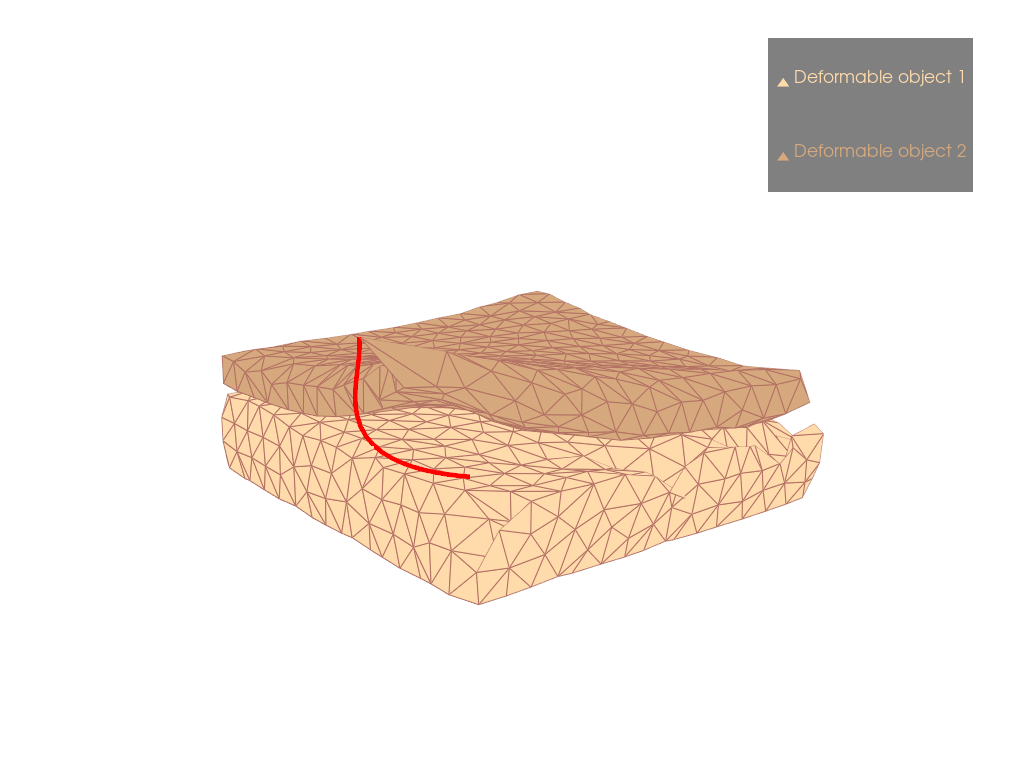

itr 16
start simulation


100%|██████████| 25/25 [00:05<00:00,  4.52it/s]


loss: tensor(1.2769, dtype=torch.float64, grad_fn=<AddBackward0>)
Accuracy: tensor(0.3651) tensor(0.9867)
avg energy: tensor([6.0943e-06], grad_fn=<DivBackward0>)
constrain tensor(0., dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([[ 29389.2033, -11322.3853,  -6678.3660],
        [  7179.9965,  -3171.3582,  -2010.1303],
        [   785.4246,   -598.8894,   -339.6584]], dtype=torch.float64)
itr 17
start simulation


100%|██████████| 25/25 [00:05<00:00,  4.60it/s]


loss: tensor(1.3163, dtype=torch.float64, grad_fn=<AddBackward0>)
Accuracy: tensor(0.3122) tensor(0.9894)
avg energy: tensor([5.6396e-06], grad_fn=<DivBackward0>)
constrain tensor(0., dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([[ -2217.3682, -10742.5469, -18763.3539],
        [   281.9619,   2010.1538,  -6099.4492],
        [   206.6059,    391.3514,   -641.3007]], dtype=torch.float64)
itr 18
start simulation


100%|██████████| 26/26 [00:05<00:00,  4.59it/s]


loss: tensor(1.2701, dtype=torch.float64, grad_fn=<AddBackward0>)
Accuracy: tensor(0.3730) tensor(0.9867)
avg energy: tensor([5.6885e-06], grad_fn=<DivBackward0>)
constrain tensor(0., dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([[ 2579.7400, -1646.7277,   195.8888],
        [  205.8775,  -316.9246,    -3.6962],
        [  -13.8512,    98.4984,   -43.5842]], dtype=torch.float64)
itr 19
start simulation


100%|██████████| 27/27 [00:05<00:00,  4.66it/s]


loss: tensor(1.2098, dtype=torch.float64, grad_fn=<AddBackward0>)
Accuracy: tensor(0.4286) tensor(0.9894)
avg energy: tensor([5.6898e-06], grad_fn=<DivBackward0>)
constrain tensor(0., dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([[ 271.1433, 1606.6556, 1734.2250],
        [  -9.7470,  552.1389,  287.9477],
        [ -22.6513,   87.7389,   15.9019]], dtype=torch.float64)
itr 20
start simulation


100%|██████████| 28/28 [00:06<00:00,  4.63it/s]


loss: tensor(1.1296, dtype=torch.float64, grad_fn=<AddBackward0>)
Accuracy: tensor(0.5132) tensor(0.9920)
avg energy: tensor([5.8933e-06], grad_fn=<DivBackward0>)
constrain tensor(0., dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([[-4575.7484, -2682.9345, -4323.8271],
        [  344.0346, -2972.5776, -1247.5999],
        [  166.2959,  -633.1127,  -151.1675]], dtype=torch.float64)


/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


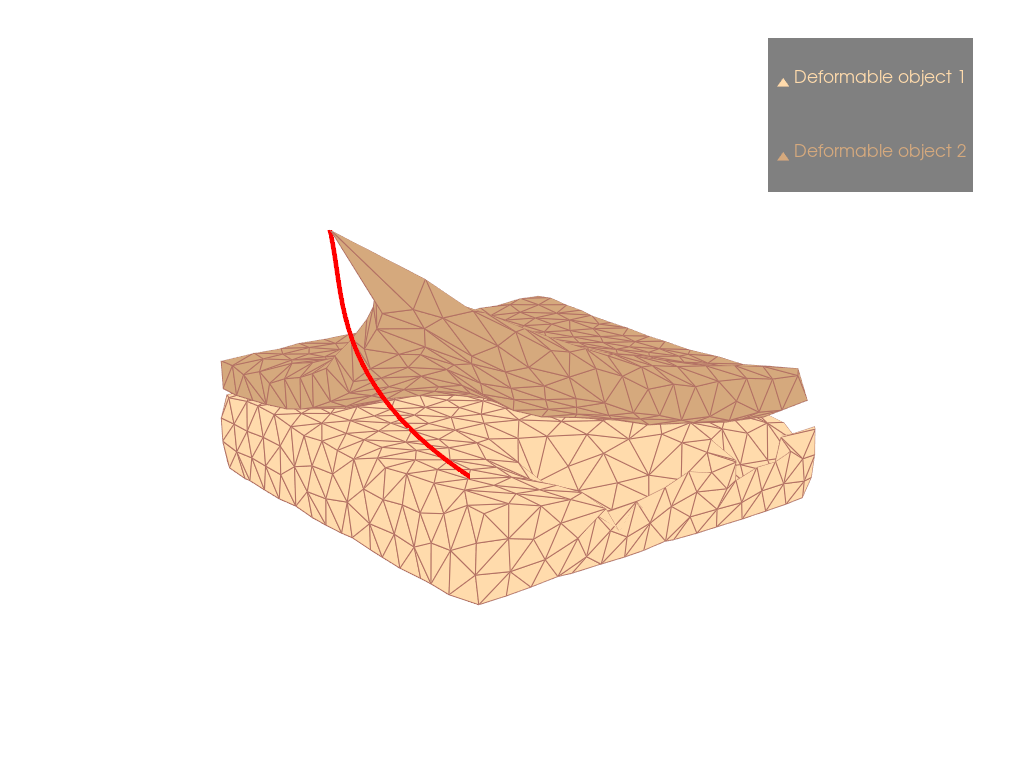

itr 21
start simulation


100%|██████████| 29/29 [00:06<00:00,  4.24it/s]


loss: tensor(1.1744, dtype=torch.float64, grad_fn=<AddBackward0>)
Accuracy: tensor(0.4418) tensor(0.9947)
avg energy: tensor([5.6099e-06], grad_fn=<DivBackward0>)
constrain tensor(0., dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([[ 1.2337e+04,  6.5654e+03,  1.3186e+04],
        [ 1.3601e+03,  7.0060e+01,  1.9722e+03],
        [ 1.2307e+01, -3.8490e+01,  7.8202e+01]], dtype=torch.float64)
itr 22
start simulation


100%|██████████| 30/30 [00:07<00:00,  4.16it/s]


loss: tensor(1.1322, dtype=torch.float64, grad_fn=<AddBackward0>)
Accuracy: tensor(0.4762) tensor(0.9973)
avg energy: tensor([5.5117e-06], grad_fn=<DivBackward0>)
constrain tensor(0., dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([[-1.2806e+04, -3.5712e+04, -3.3455e+04],
        [-1.1572e+03, -4.1817e+03, -2.2713e+03],
        [-7.8729e+01,  9.9785e+01, -8.6250e+00]], dtype=torch.float64)
itr 23
start simulation


100%|██████████| 31/31 [00:07<00:00,  4.17it/s]


loss: tensor(1.0602, dtype=torch.float64, grad_fn=<AddBackward0>)
Accuracy: tensor(0.5423) tensor(0.9973)
avg energy: tensor([5.8225e-06], grad_fn=<DivBackward0>)
constrain tensor(0., dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([[-938614.0059, 1217905.4874, -170795.9867],
        [-122329.8728,  417492.5876,  -35202.1730],
        [  -5453.8058,   46797.4908,   -3931.9380]], dtype=torch.float64)
itr 24
start simulation


100%|██████████| 31/31 [00:07<00:00,  4.04it/s]


loss: tensor(1.0617, dtype=torch.float64, grad_fn=<AddBackward0>)
Accuracy: tensor(0.5741) tensor(0.9867)
avg energy: tensor([6.0177e-06], grad_fn=<DivBackward0>)
constrain tensor(0., dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([[ 29226.4386, -22110.6750,   1752.6218],
        [   161.5483,  -2417.2397,   4318.2111],
        [  -153.5837,     99.1895,    112.3625]], dtype=torch.float64)
itr 25
start simulation


100%|██████████| 32/32 [00:07<00:00,  4.40it/s]


loss: tensor(1.0689, dtype=torch.float64, grad_fn=<AddBackward0>)
Accuracy: tensor(0.5635) tensor(0.9867)
avg energy: tensor([6.6408e-06], grad_fn=<DivBackward0>)
constrain tensor(0., dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([[-50357.2556, 248361.7262, 153099.1752],
        [-26680.9303, 168561.8964, -34270.0391],
        [ -4971.9266,  23945.7434,  -3312.0631]], dtype=torch.float64)


/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


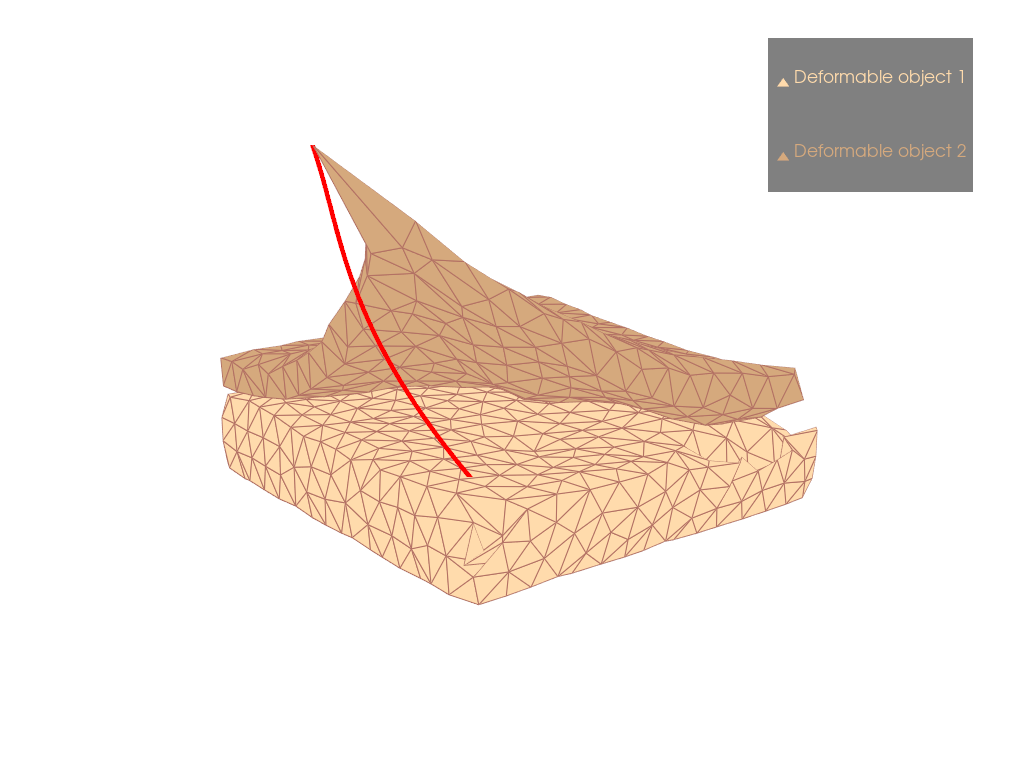

itr 26
start simulation


100%|██████████| 34/34 [00:07<00:00,  4.47it/s]


loss: tensor(1.1195, dtype=torch.float64, grad_fn=<AddBackward0>)
Accuracy: tensor(0.6296) tensor(0.9707)
avg energy: tensor([7.5385e-06], grad_fn=<DivBackward0>)
constrain tensor(0., dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([[ 374877.5377, -339560.5151,  -71225.4543],
        [  55697.0935,  -59362.2990,   12891.7738],
        [   3164.4186,   -3975.2322,    1727.0944]], dtype=torch.float64)
itr 27
start simulation


100%|██████████| 35/35 [00:07<00:00,  4.39it/s]


loss: tensor(1.0918, dtype=torch.float64, grad_fn=<AddBackward0>)
Accuracy: tensor(0.7222) tensor(0.9734)
avg energy: tensor([8.3162e-06], grad_fn=<DivBackward0>)
constrain tensor(0., dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([[-2528.5573,   133.5931,   -47.2551],
        [-2965.6700,  1022.7880,  -563.5555],
        [ -363.1844,   219.1899,  -194.4912]], dtype=torch.float64)
itr 28
start simulation


100%|██████████| 37/37 [00:08<00:00,  4.40it/s]


loss: tensor(1.1693, dtype=torch.float64, grad_fn=<AddBackward0>)
Accuracy: tensor(0.7831) tensor(0.8617)
avg energy: tensor([9.1246e-06], grad_fn=<DivBackward0>)
constrain tensor(0., dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([[ 107665.1302, -231018.0525, -109767.3981],
        [  22573.2303,  -51036.5953,  -14251.1874],
        [   2280.3315,   -3667.0882,   -1010.1423]], dtype=torch.float64)
itr 29
start simulation


100%|██████████| 38/38 [00:08<00:00,  4.57it/s]


loss: tensor(1.2239, dtype=torch.float64, grad_fn=<AddBackward0>)
Accuracy: tensor(0.8095) tensor(0.8245)
avg energy: tensor([9.3941e-06], grad_fn=<DivBackward0>)
constrain tensor(0., dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([[-1.1459e+05,  4.0990e+05,  2.5179e+05],
        [-1.0407e+04,  1.2682e+05,  7.4534e+03],
        [ 8.8627e+02,  1.0970e+04,  3.6276e+02]], dtype=torch.float64)
itr 30
start simulation


100%|██████████| 39/39 [00:08<00:00,  4.57it/s]


loss: tensor(1.2726, dtype=torch.float64, grad_fn=<AddBackward0>)
Accuracy: tensor(0.8280) tensor(0.7633)
avg energy: tensor([9.9943e-06], grad_fn=<DivBackward0>)
constrain tensor(0., dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([[-1917460.5855,  3223101.6394,  1733968.1204],
        [ -203449.0734,   375066.7888,   162039.0491],
        [  -21194.7016,    17863.1430,     6551.3991]], dtype=torch.float64)


/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


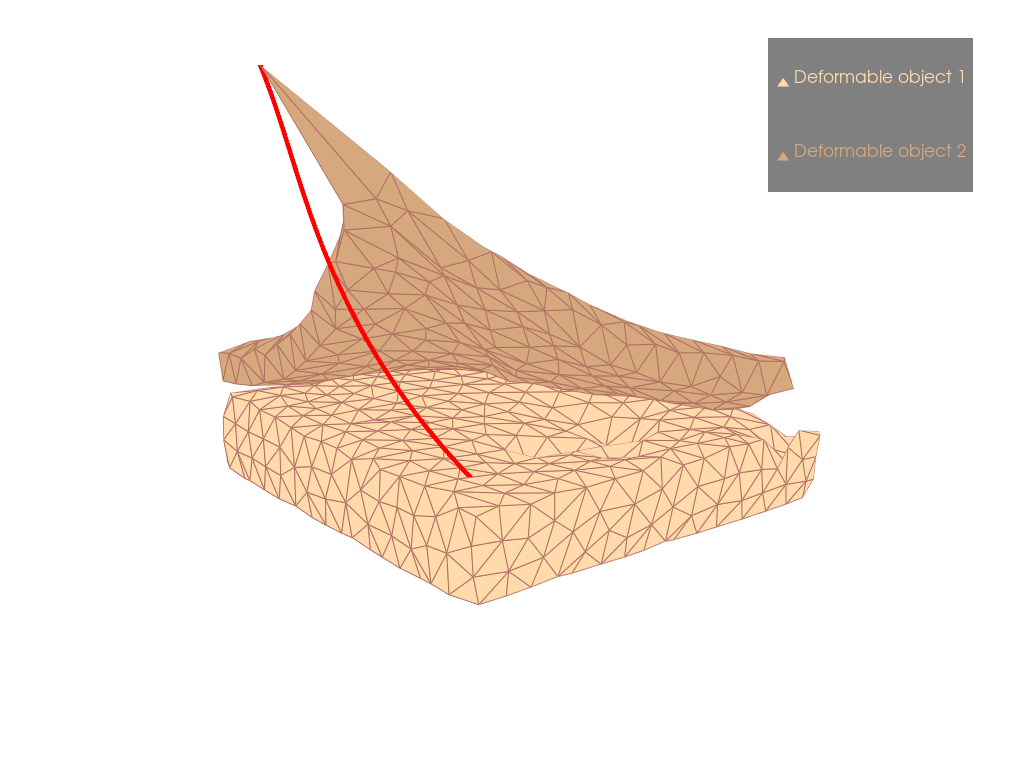

itr 31
start simulation


100%|██████████| 39/39 [00:08<00:00,  4.80it/s]


loss: tensor(1.3228, dtype=torch.float64, grad_fn=<AddBackward0>)
Accuracy: tensor(0.8466) tensor(0.7367)
avg energy: tensor([1.0611e-05], grad_fn=<DivBackward0>)
constrain tensor(0., dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([[-3.7861e+06,  6.9577e+05, -9.6054e+04],
        [-3.3244e+05,  2.0202e+05, -1.0731e+05],
        [-1.5506e+04,  1.4293e+04, -3.0109e+03]], dtype=torch.float64)
itr 32
start simulation


100%|██████████| 40/40 [00:09<00:00,  4.39it/s]


loss: tensor(1.4221, dtype=torch.float64, grad_fn=<AddBackward0>)
Accuracy: tensor(0.9101) tensor(0.6569)
avg energy: tensor([1.1805e-05], grad_fn=<DivBackward0>)
constrain tensor(0., dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([[ 910632.4282, -606362.3207, -238211.0120],
        [ 101567.9813, -160789.3788, -174896.6679],
        [   2459.2831,  -23717.8309,  -12765.2989]], dtype=torch.float64)
itr 33
start simulation


100%|██████████| 41/41 [00:08<00:00,  4.56it/s]


loss: tensor(1.4787, dtype=torch.float64, grad_fn=<AddBackward0>)
Accuracy: tensor(0.9233) tensor(0.6144)
avg energy: tensor([1.2498e-05], grad_fn=<DivBackward0>)
constrain tensor(0., dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([[4.7248e+06, 9.3447e+05, 1.3383e+06],
        [5.0265e+05, 1.7017e+05, 8.8717e+04],
        [2.2320e+04, 9.8370e+03, 6.1387e+02]], dtype=torch.float64)
itr 34
start simulation


100%|██████████| 43/43 [00:09<00:00,  4.37it/s]


loss: tensor(1.5707, dtype=torch.float64, grad_fn=<AddBackward0>)
Accuracy: tensor(0.9127) tensor(0.5745)
avg energy: tensor([1.3063e-05], grad_fn=<DivBackward0>)
constrain tensor(0., dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([[-1.5536e+08,  2.4205e+07,  1.6564e+07],
        [-2.0910e+07,  2.4198e+05,  3.2047e+06],
        [-1.0156e+06, -2.1616e+05,  2.2912e+05]], dtype=torch.float64)
itr 35
start simulation


100%|██████████| 42/42 [00:09<00:00,  4.42it/s]


loss: tensor(1.5291, dtype=torch.float64, grad_fn=<AddBackward0>)
Accuracy: tensor(0.9180) tensor(0.5851)
avg energy: tensor([1.3264e-05], grad_fn=<DivBackward0>)
constrain tensor(0., dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([[-3921263.0837,  1530569.2173,  2599106.6321],
        [ -637001.9944,   561986.9380,   255352.5323],
        [  -36971.2502,    39460.6762,     9601.0575]], dtype=torch.float64)


/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


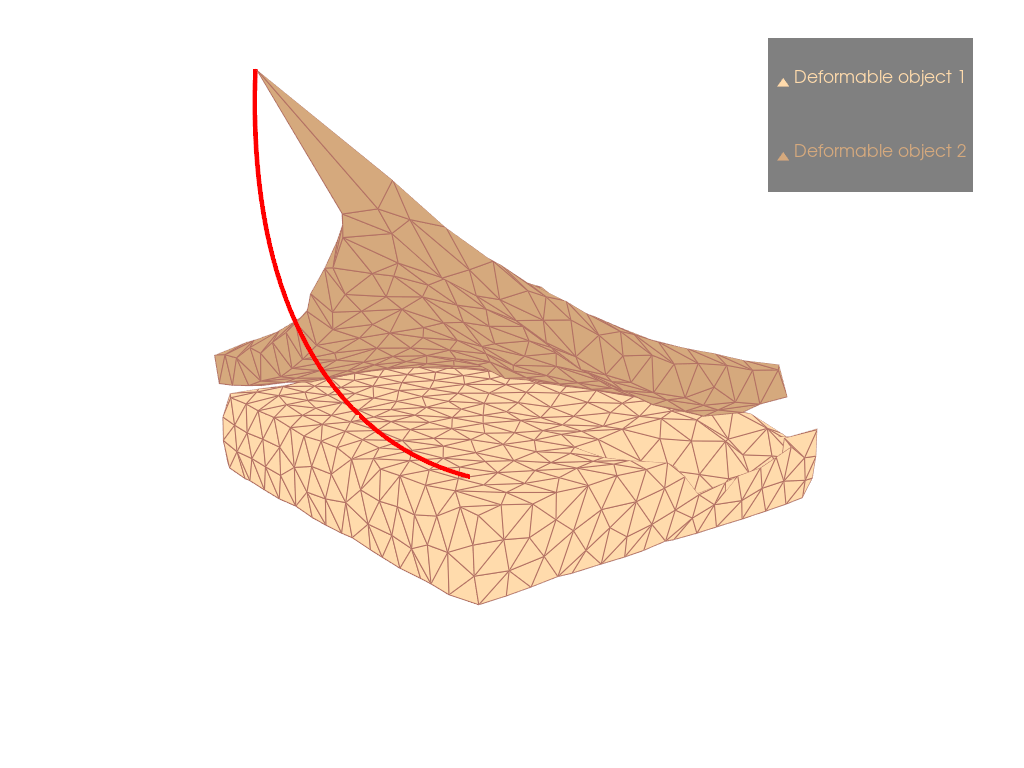

itr 36
start simulation


100%|██████████| 42/42 [00:09<00:00,  4.49it/s]


loss: tensor(1.5240, dtype=torch.float64, grad_fn=<AddBackward0>)
Accuracy: tensor(0.9074) tensor(0.5878)
avg energy: tensor([1.3712e-05], grad_fn=<DivBackward0>)
constrain tensor(0., dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([[-233236.2610,   74234.2287,  198761.5685],
        [ -25817.3362,   21406.3662,   19218.6140],
        [  -2609.3544,    1326.4886,     374.9582]], dtype=torch.float64)
itr 37
start simulation


100%|██████████| 42/42 [00:09<00:00,  4.44it/s]


loss: tensor(1.5075, dtype=torch.float64, grad_fn=<AddBackward0>)
Accuracy: tensor(0.8730) tensor(0.5984)
avg energy: tensor([1.3861e-05], grad_fn=<DivBackward0>)
constrain tensor(0., dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([[-10826.9800,  -4896.8247,  -4624.3437],
        [ -4688.1130,   -310.2662,  -1290.8170],
        [  -738.4089,   -136.1240,   -136.7732]], dtype=torch.float64)
itr 38
start simulation


100%|██████████| 42/42 [00:10<00:00,  4.06it/s]


KeyboardInterrupt: 

In [33]:

# pl.open_gif(filename)
for t in range(120):
    print('itr', t)
    # get cubic bezier spline control after step
    x_con = torch.cat((start_point[:, 0], spline_control[:, 0]))
    y_con = torch.cat((start_point[:, 1], spline_control[:, 1]))
    z_con = torch.cat((start_point[:, 2], spline_control[:, 2]))
    spline = cubic_bezier_arc_3D(x_con, y_con, z_con, 0.0005)
    spline_x = spline[0]
    spline_y = spline[1]
    spline_z = spline[2]
    spline_trajectory = torch.transpose(torch.vstack((spline_x, spline_y, spline_z)), 0, 1)
    # print(spline_trajectory)
    # restore original vertex and velocity
    softbody.V = V_origin.clone()
    softbody.V_velocity = V_velocity_origin.clone()

    # restore stiffness
    cloth_dist_stiffness = 0.1
    V_boundary_stiffness_ref = 0.1
    V_dist_stiffness = torch.ones_like(softbody.V_mass).to(cfg.device) * cloth_dist_stiffness
    V_boundary_stiffness = torch.ones((softbody.C_boundary_list[0].shape[0], 1)).to(cfg.device) * V_boundary_stiffness_ref
    V_boundary_stiffness = V_boundary_stiffness.type(torch.DoubleTensor)
    V_shape_stiffness = torch.ones_like(softbody.V_mass).to(cfg.device)*0.0005
    print('start simulation')
    energy_total = torch.zeros(1)
    for i in trange(spline_trajectory.shape[0]):
    # for i in range(1):
        softbody.V[softbody.offset_list[1] + control_point] = spline_trajectory[i]
        
        step_ref = XPBDStep(softbody,
                    V_dist_stiffness=V_dist_stiffness, 
                    V_shape_stiffness=V_shape_stiffness,
                    V_boundary_stiffness=V_boundary_stiffness, 
                    dt=cfg.dt,
                    substep=cfg.substep,
                    iteration=cfg.iteration,
                    quasi_static=cfg.quasi_static,
                    plane_height=cfg.ground_plane_height, 
                    use_shape_matching=True,
                    use_spring_boundary=True,
                    use_dist=True)
        V_ref, V_velocity_ref = step_ref.forward(softbody.V, softbody.V_velocity)
        softbody.V = V_ref.clone()
        softbody.V_velocity = V_velocity_ref.clone()
        # print((softbody.V == torch.inf).any())
        ref_V_boundary_stiffness = V_boundary_stiffness.clone()
        energy = get_energy_boundary(softbody, softbody.V, ref_V_boundary_stiffness)
        V_boundary_stiffness = V_boundary_stiffness * torch.sigmoid(energy_coff * (energy_threshold - energy)) + 1e-8 * torch.sigmoid(energy_coff * (energy - energy_threshold))
        energy_total += torch.sum(energy)
        # V_boundary_stiffness = (V_boundary_stiffness * energy_level + V_boundary_stiffness) / 2 + (1e-8 * (-energy_level) + 1e-8) / 2
        # V_boundary_stiffness = V_boundary_stiffness * torch.sigmoid(9 * energy_level) + 1e-8 * torch.sigmoid(9 * energy_level)
        skin_mesh.points = softbody.V[:p_skin].detach().cpu().numpy()
        bandage_mesh.points = softbody.V[p_skin:].detach().cpu().numpy()

    # loss = torch.norm(V_boundary_stiffness)
    energy_avg = energy_total / spline_trajectory.shape[0]
    constrain = torch.sigmoid(1e8 * (start_point[:, 2] - spline_trajectory[1:, 2]))
    constrain = torch.sum(constrain)
    TT_score, NN_score = eval(V_boundary_stiffness, boundary_mask)
    loss = loss_fn(V_boundary_stiffness, boundary_mask, constrain, energy_avg, alpha=0, beta=TT_score)
    loss.backward()
    
    print('loss:', loss)
    print('Accuracy:', TT_score, NN_score)
    print('avg energy:', energy_avg)
    print('constrain', constrain)
    print(spline_control.grad)
    spline_list.append(spline_trajectory)
    if t % 5 == 0:
        pl = pv.Plotter()
        pl.add_mesh(skin_mesh, color='#ffdbac', show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Deformable object 1')
        pl.add_mesh(bandage_mesh, color='#D5A97D', show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Deformable object 2')
        pl.add_lines(spline_trajectory.detach().cpu().numpy(), connected=True, color='r')
        # pl.add_mesh(bandage_mesh, scalars=color, show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Bandage')
        pl.add_legend()
        pl.camera_position = [(0.04943279151406822, -0.03977536222547223, 0.021820325700180415),
 (7.301401243626354e-06, 2.0879731106636726e-05, 0.003000000142492353),
 (-0.23015530645193596, 0.1675075959527941, 0.95862909418092)]
        pl.show()
        
    optimizer.step()
    optimizer.zero_grad()

# pl.close()

In [ ]:
# pl = pv.Plotter()
# pl.add_mesh(skin_mesh, color='#ffdbac', show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Deformable object 1')
# pl.add_mesh(bandage_mesh, color='#D5A97D', show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Deformable object 2')
# pl.add_text('Accuracy: tensor(0.6848) tensor(0.9204)')
# # pl.add_mesh(bandage_mesh, scalars=color, show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Bandage')
# pl.add_legend()
# pl.camera_position = 'iso'

In [ ]:
# pl.open_gif('tis2tis_stiffness_scenario10_itr10.gif')
# softbody.V = V_origin.clone()
# softbody.V_velocity = V_velocity_origin.clone()

# # restore stiffness
# cloth_dist_stiffness = 1
# V_boundary_stiffness_ref = 10
# V_dist_stiffness = torch.ones_like(softbody.V_mass).to(cfg.device)
# V_boundary_stiffness = torch.ones((softbody.C_boundary_list[0].shape[0], 1)).to(cfg.device) * V_boundary_stiffness_ref
# V_shape_stiffness = torch.ones_like(softbody.V_mass).to(cfg.device)*0.001
# V_shape_stiffness[:600] = 0.001
# V_shape_stiffness[600:] = 0.000001
# V_dist_stiffness[:600] = 1
# V_dist_stiffness[600:] = 0.1
# spline_trajectory = spline_list[7]
# spline_actor = pl.add_lines(spline_trajectory.detach().cpu().numpy(), connected=True, color='r')

# for i in trange(spline_trajectory.shape[0]):
#     softbody.V[softbody.offset_list[1] + control_point] = spline_trajectory[i]
    
#     step_ref = XPBDStep(softbody,
#                 V_dist_stiffness=V_dist_stiffness, 
#                 V_shape_stiffness=V_shape_stiffness,
#                 V_boundary_stiffness=V_boundary_stiffness, 
#                 dt=cfg.dt,
#                 substep=cfg.substep,
#                 iteration=cfg.iteration,
#                 quasi_static=cfg.quasi_static,
#                 plane_height=cfg.ground_plane_height, 
#                 use_shape_matching=True,
#                 use_spring_boundary=True,
#                 use_dist=True)
#     V_ref, V_velocity_ref = step_ref.forward(softbody.V, softbody.V_velocity)
#     softbody.V = V_ref.clone()
#     softbody.V_velocity = V_velocity_ref.clone()
#     # print((softbody.V == torch.inf).any())
#     ref_V_boundary_stiffness = V_boundary_stiffness.clone()
#     energy = get_energy_boundary(softbody, softbody.V, ref_V_boundary_stiffness)
#     V_boundary_stiffness = V_boundary_stiffness * torch.sigmoid(energy_coff * (energy_threshold - energy)) + 1e-8 * torch.sigmoid(energy_coff * (energy - energy_threshold))
#     skin_mesh.points = softbody.V[:N_skin].detach().cpu().numpy()
#     bandage_mesh.points = softbody.V[N_skin:N_bandage+N_skin].detach().cpu().numpy()
#     # print(V_boundary_stiffness)
#     pl.write_frame()
# # pl.add_text('Accuracy: (tensor(0.8880), tensor(0.9057))')
# # loss = torch.norm(V_boundary_stiffness)

# pl.close()

In [ ]:
# picked_trajectory = spline_list[20]

In [ ]:
# mirror_trajectory = picked_trajectory.clone()

In [ ]:
# rot = np.array([[np.cos(-np.pi/4), -np.sin(-np.pi/4)],
#                 [np.sin(-np.pi/4), np.cos(-np.pi/4)]])
# rot = torch.from_numpy(rot)

In [ ]:
# for i in range(mirror_trajectory.shape[0]):
#     mirror_trajectory[i, :2] = mirror_trajectory[i, :2] @ rot

In [ ]:
# for i in range(mirror_trajectory.shape[0]):
#     mirror_trajectory[i, 1] = -mirror_trajectory[i, 1]

In [ ]:
# rot = np.array([[np.cos(np.pi/4), -np.sin(np.pi/4)],
#                 [np.sin(np.pi/4), np.cos(np.pi/4)]])
# rot = torch.from_numpy(rot)

In [ ]:
# for i in range(mirror_trajectory.shape[0]):
#     mirror_trajectory[i, :2] = mirror_trajectory[i, :2] @ rot

In [ ]:
# pl = pv.Plotter()
# pl.add_mesh(skin_mesh, color='#ffdbac', show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Deformable object 1')
# pl.add_mesh(bandage_mesh, color='#D5A97D', show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Deformable object 2')
# pl.add_text('Accuracy: tensor(0.6848) tensor(0.9204)')
# pl.add_lines(mirror_trajectory.detach().cpu().numpy(), connected=True, color='r')
# pl.add_lines(picked_trajectory.detach().cpu().numpy(), connected=True, color='b')
# pl.add_legend()
# pl.camera_position = 'iso'
# pl.show()

In [ ]:
# spline_trajectory = picked_trajectory
# # print(spline_trajectory)
# # restore original vertex and velocity
# softbody.V = V_origin.clone()
# softbody.V_velocity = V_velocity_origin.clone()

# # restore stiffness
# cloth_dist_stiffness = 1
# V_boundary_stiffness_ref = 10
# V_dist_stiffness = torch.ones_like(softbody.V_mass).to(cfg.device)
# V_boundary_stiffness = torch.ones((softbody.C_boundary_list[0].shape[0], 1)).to(cfg.device) * V_boundary_stiffness_ref
# V_shape_stiffness = torch.ones_like(softbody.V_mass).to(cfg.device)*0.001
# V_shape_stiffness[:600] = 0.001
# V_shape_stiffness[600:] = 0.000001
# V_dist_stiffness[:600] = 1
# V_dist_stiffness[600:] = 0.1
# print('start simulation')
# energy_total = torch.zeros(1)
# energy_list = []
# for i in trange(spline_trajectory.shape[0]):
# # for i in range(1):
#     softbody.V[softbody.offset_list[1] + control_point] = spline_trajectory[i]
    
#     step_ref = XPBDStep(softbody,
#                 V_dist_stiffness=V_dist_stiffness, 
#                 V_shape_stiffness=V_shape_stiffness,
#                 V_boundary_stiffness=V_boundary_stiffness, 
#                 dt=cfg.dt,
#                 substep=cfg.substep,
#                 iteration=cfg.iteration,
#                 quasi_static=cfg.quasi_static,
#                 plane_height=cfg.ground_plane_height, 
#                 use_shape_matching=True,
#                 use_spring_boundary=True,
#                 use_dist=True)
#     V_ref, V_velocity_ref = step_ref.forward(softbody.V, softbody.V_velocity)
#     softbody.V = V_ref.clone()
#     softbody.V_velocity = V_velocity_ref.clone()
#     # print((softbody.V == torch.inf).any())
#     ref_V_boundary_stiffness = V_boundary_stiffness.clone()
#     energy = get_energy_boundary(softbody, softbody.V, ref_V_boundary_stiffness)
#     V_boundary_stiffness = V_boundary_stiffness * torch.sigmoid(energy_coff * (energy_threshold - energy)) + 1e-8 * torch.sigmoid(energy_coff * (energy - energy_threshold))
#     energy_total += torch.sum(energy)
#     energy_list.append(torch.sum(energy).detach().cpu().numpy())
#     # V_boundary_stiffness = (V_boundary_stiffness * energy_level + V_boundary_stiffness) / 2 + (1e-8 * (-energy_level) + 1e-8) / 2
#     # V_boundary_stiffness = V_boundary_stiffness * torch.sigmoid(9 * energy_level) + 1e-8 * torch.sigmoid(9 * energy_level)
#     skin_mesh.points = softbody.V[:N_skin].detach().cpu().numpy()
#     bandage_mesh.points = softbody.V[N_skin:N_bandage+N_skin].detach().cpu().numpy()

# # loss = torch.norm(V_boundary_stiffness)
# energy_avg = energy_total / spline_trajectory.shape[0]
# constrain = torch.sigmoid(1e8 * (start_point[:, 2] - spline_trajectory[1:, 2]))
# constrain = torch.sum(constrain)
# TT_score, NN_score = eval(V_boundary_stiffness, boundary_mask)
# loss = loss_fn(V_boundary_stiffness, boundary_mask, constrain, energy_avg, alpha=0, beta=TT_score)

# print('loss:', loss)
# print('Accuracy:', TT_score, NN_score)
# print('avg energy:', energy_avg)
# print('constrain', constrain)
# print(spline_control.grad)
# spline_list.append(spline_trajectory)
# pl = pv.Plotter()
# pl.add_mesh(skin_mesh, color='#ffdbac', show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Deformable object 1')
# pl.add_mesh(bandage_mesh, color='#D5A97D', show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Deformable object 2')
# pl.add_lines(spline_trajectory.detach().cpu().numpy(), connected=True, color='r')
# # pl.add_mesh(bandage_mesh, scalars=color, show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Bandage')
# pl.add_legend()
# pl.camera_position = [(0.04943279151406822, -0.03977536222547223, 0.021820325700180415),
# (7.301401243626354e-06, 2.0879731106636726e-05, 0.003000000142492353),
# (-0.23015530645193596, 0.1675075959527941, 0.95862909418092)]
# pl.show()
    

# # pl.close()

In [ ]:
energy_1 = energy_list.copy()

NameError: name 'energy_list' is not defined

start simulation


100%|██████████| 59/59 [00:12<00:00,  4.72it/s]


loss: tensor([1.9355], grad_fn=<AddBackward0>)
Accuracy: tensor(0.8578) tensor(0.9532)
avg energy: tensor([6.5132e-06], grad_fn=<DivBackward0>)
constrain tensor(17., dtype=torch.float64, grad_fn=<SumBackward0>)
None


/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


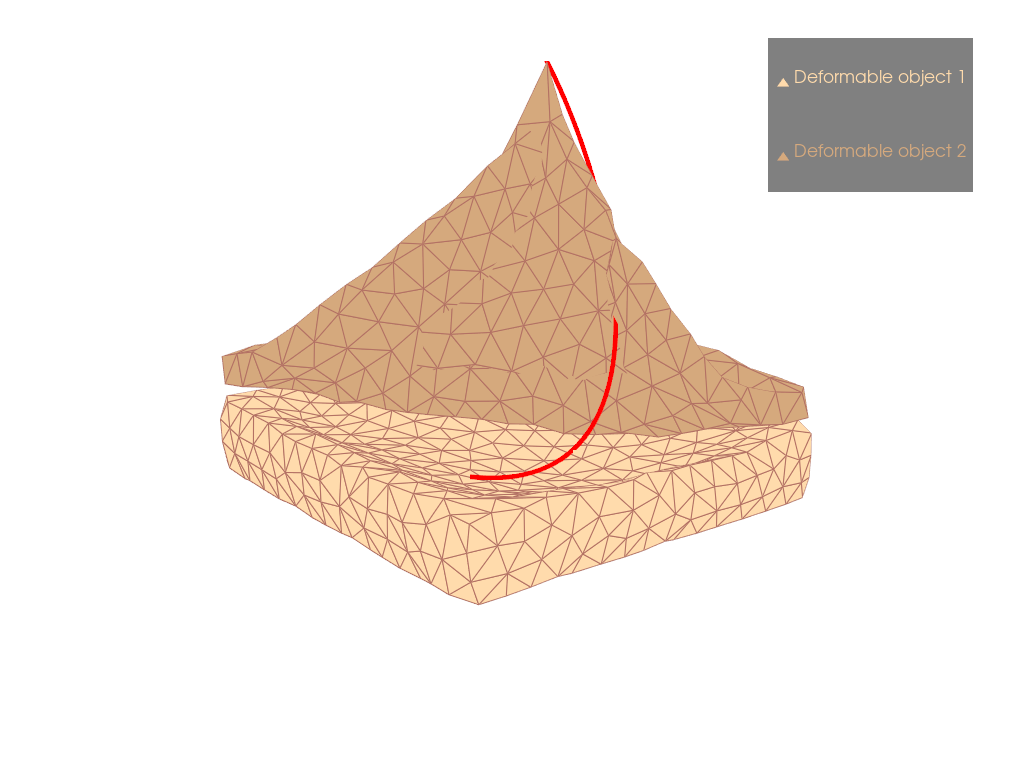

In [ ]:
spline_trajectory = mirror_trajectory
# print(spline_trajectory)
# restore original vertex and velocity
softbody.V = V_origin.clone()
softbody.V_velocity = V_velocity_origin.clone()

# restore stiffness
cloth_dist_stiffness = 1
V_boundary_stiffness_ref = 10
V_dist_stiffness = torch.ones_like(softbody.V_mass).to(cfg.device)
V_boundary_stiffness = torch.ones((softbody.C_boundary_list[0].shape[0], 1)).to(cfg.device) * V_boundary_stiffness_ref
V_shape_stiffness = torch.ones_like(softbody.V_mass).to(cfg.device)*0.001
V_shape_stiffness[:600] = 0.001
V_shape_stiffness[600:] = 0.000001
V_dist_stiffness[:600] = 1
V_dist_stiffness[600:] = 0.1
print('start simulation')
energy_total = torch.zeros(1)
energy_list = []
for i in trange(spline_trajectory.shape[0]):
# for i in range(1):
    softbody.V[softbody.offset_list[1] + control_point] = spline_trajectory[i]
    
    step_ref = XPBDStep(softbody,
                V_dist_stiffness=V_dist_stiffness, 
                V_shape_stiffness=V_shape_stiffness,
                V_boundary_stiffness=V_boundary_stiffness, 
                dt=cfg.dt,
                substep=cfg.substep,
                iteration=cfg.iteration,
                quasi_static=cfg.quasi_static,
                plane_height=cfg.ground_plane_height, 
                use_shape_matching=True,
                use_spring_boundary=True,
                use_dist=True)
    V_ref, V_velocity_ref = step_ref.forward(softbody.V, softbody.V_velocity)
    softbody.V = V_ref.clone()
    softbody.V_velocity = V_velocity_ref.clone()
    # print((softbody.V == torch.inf).any())
    ref_V_boundary_stiffness = V_boundary_stiffness.clone()
    energy = get_energy_boundary(softbody, softbody.V, ref_V_boundary_stiffness)
    V_boundary_stiffness = V_boundary_stiffness * torch.sigmoid(energy_coff * (energy_threshold - energy)) + 1e-8 * torch.sigmoid(energy_coff * (energy - energy_threshold))
    energy_total += torch.sum(energy)
    energy_list.append(torch.sum(energy).detach().cpu().numpy())
    # V_boundary_stiffness = (V_boundary_stiffness * energy_level + V_boundary_stiffness) / 2 + (1e-8 * (-energy_level) + 1e-8) / 2
    # V_boundary_stiffness = V_boundary_stiffness * torch.sigmoid(9 * energy_level) + 1e-8 * torch.sigmoid(9 * energy_level)
    skin_mesh.points = softbody.V[:N_skin].detach().cpu().numpy()
    bandage_mesh.points = softbody.V[N_skin:N_bandage+N_skin].detach().cpu().numpy()

# loss = torch.norm(V_boundary_stiffness)
energy_avg = energy_total / spline_trajectory.shape[0]
constrain = torch.sigmoid(1e8 * (start_point[:, 2] - spline_trajectory[1:, 2]))
constrain = torch.sum(constrain)
TT_score, NN_score = eval(V_boundary_stiffness, boundary_mask)
loss = loss_fn(V_boundary_stiffness, boundary_mask, constrain, energy_avg, alpha=0, beta=TT_score)

print('loss:', loss)
print('Accuracy:', TT_score, NN_score)
print('avg energy:', energy_avg)
print('constrain', constrain)
print(spline_control.grad)
spline_list.append(spline_trajectory)
pl = pv.Plotter()
pl.add_mesh(skin_mesh, color='#ffdbac', show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Deformable object 1')
pl.add_mesh(bandage_mesh, color='#D5A97D', show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Deformable object 2')
pl.add_lines(spline_trajectory.detach().cpu().numpy(), connected=True, color='r')
# pl.add_mesh(bandage_mesh, scalars=color, show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Bandage')
pl.add_legend()
pl.camera_position = [(0.04943279151406822, -0.03977536222547223, 0.021820325700180415),
(7.301401243626354e-06, 2.0879731106636726e-05, 0.003000000142492353),
(-0.23015530645193596, 0.1675075959527941, 0.95862909418092)]
pl.show()
    

# pl.close()

In [ ]:
energy_2 = energy_list.copy()

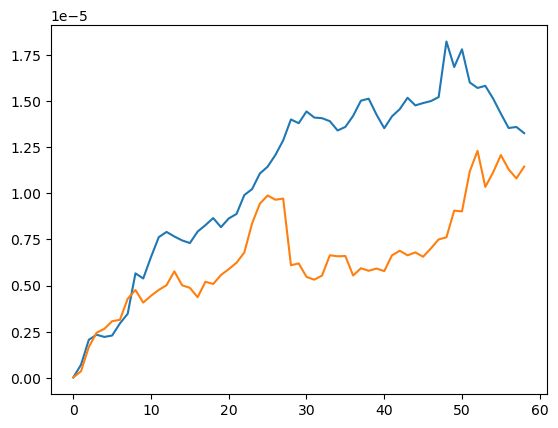

In [ ]:
plt.plot(energy_1)
plt.plot(energy_2)